In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, RandomFlip, RandomRotation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import os

# --- ⚙️ Configuration ---
PROCESSED_DATA_DIR = '../data/fer2013_processed/'
MODEL_OUTPUT_DIR = '../models/'
# Filenames for the final tuned model
PLOT_SAVE_PATH = os.path.join(MODEL_OUTPUT_DIR, 'final_tuned_vgg16_performance.png')
MODEL_SAVE_PATH = os.path.join(MODEL_OUTPUT_DIR, 'final_tuned_vgg16_model.h5')

# Model parameters
NUM_CLASSES = 7
IMG_WIDTH, IMG_HEIGHT = 48, 48
EPOCHS = 50
BATCH_SIZE = 64

def load_and_prepare_data(data_dir):
    """Loads grayscale data and converts it to 3-channel for the model."""
    print("Loading and preparing data...")
    try:
        X_train_grayscale = np.load(os.path.join(data_dir, 'X_train.npy'))
        y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
        X_val_grayscale = np.load(os.path.join(data_dir, 'X_val.npy'))
        y_val = np.load(os.path.join(data_dir, 'y_val.npy'))

        X_train_3_channel = np.repeat(X_train_grayscale, 3, axis=-1)
        X_val_3_channel = np.repeat(X_val_grayscale, 3, axis=-1)
        
        y_train = to_categorical(y_train, num_classes=NUM_CLASSES)
        y_val = to_categorical(y_val, num_classes=NUM_CLASSES)
        
        print(f"Data prepared successfully. New shape: {X_train_3_channel.shape} ✅")
        return X_train_3_channel, y_train, X_val_3_channel, y_val
    except FileNotFoundError:
        print(f"--- 🔴 ERROR: Preprocessed data not found in '{data_dir}' ---")
        return None, None, None, None

def build_final_tuned_vgg16_model():
    """Builds the final tuned VGG16 model with strong regularization."""
    print("Building final tuned VGG16 model...")

    data_augmentation = Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
    ], name="data_augmentation")

    inputs = tf.keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    x = data_augmentation(inputs)
    
    base_model = VGG16(weights='imagenet', include_top=False, input_tensor=x)
    
    base_model.trainable = True
    for layer in base_model.layers[:-4]:
        layer.trainable = False
        
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.6)(x) 
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def plot_performance(history):
    """Plots the model's training and validation accuracy and loss."""
    print("\n--- 📊 Plotting Model Performance ---")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.savefig(PLOT_SAVE_PATH)
    print(f"Performance plot saved to: {PLOT_SAVE_PATH}")
    plt.show()

def train_final_tuned_model():
    """Main function to run the final tuned training process."""
    X_train, y_train, X_val, y_val = load_and_prepare_data(PROCESSED_DATA_DIR)
    if X_train is None: return

    model = build_final_tuned_vgg16_model()
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    
    print("\n--- 🧠 Starting Final Tuned VGG16 Model Training ---")
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )
    print("--- ✅ Model Training Complete ---")
    
    if not os.path.exists(MODEL_OUTPUT_DIR):
        os.makedirs(MODEL_OUTPUT_DIR)
    
    model.save(MODEL_SAVE_PATH)
    print(f"\nFinal tuned model saved successfully to: {MODEL_SAVE_PATH}")
    
    # This automatically calls the plotting function with the results from your training run
    plot_performance(history)

Loading and preparing data...
Data prepared successfully. New shape: (28709, 48, 48, 3) ✅
Building final tuned VGG16 model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 1, 1, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 7,212,551 (27.51 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


--- 🧠 Starting Final Tuned VGG16 Model Training ---
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 353s 776ms/step - accuracy: 0.3510 - loss: 3.6195 - val_accuracy: 0.4511 - val_loss: 2.4475 - learning_rate: 1.0000e-04
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 340s 758ms/step - accuracy: 0.4412 - loss: 2.0930 - val_accuracy: 0.4877 - val_loss: 1.7068 - learning_rate: 1.0000e-04
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 287s 640ms/step - accuracy: 0.4698 - loss: 1.6809 - val_accuracy: 0.5060 - val_loss: 1.5197 - learning_rate: 1.0000e-04
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 287s 639ms/step - accuracy: 0.4916 - loss: 1.5406 - val_accuracy: 0.5088 - val_loss: 1.4513 - learning_rate: 1.0000e-04
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 635ms/step - accuracy: 0.5103 - loss: 1.4484 - val_accuracy: 0.5166 - val_loss: 1.3899 - learning_rate: 1.0000e-04
Epoch 6/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 285s 634ms/step - accuracy: 0.5286 - loss: 1.3897 - val_accuracy: 0.5240 - val_loss: 1.3676 - learning_rate

--- ✅ Model Training Complete ---

Final tuned model saved successfully to: ../models/final_tuned_vgg16_model.h5

--- 📊 Plotting Model Performance ---
Performance plot saved to: ../models/final_tuned_vgg16_performance.png


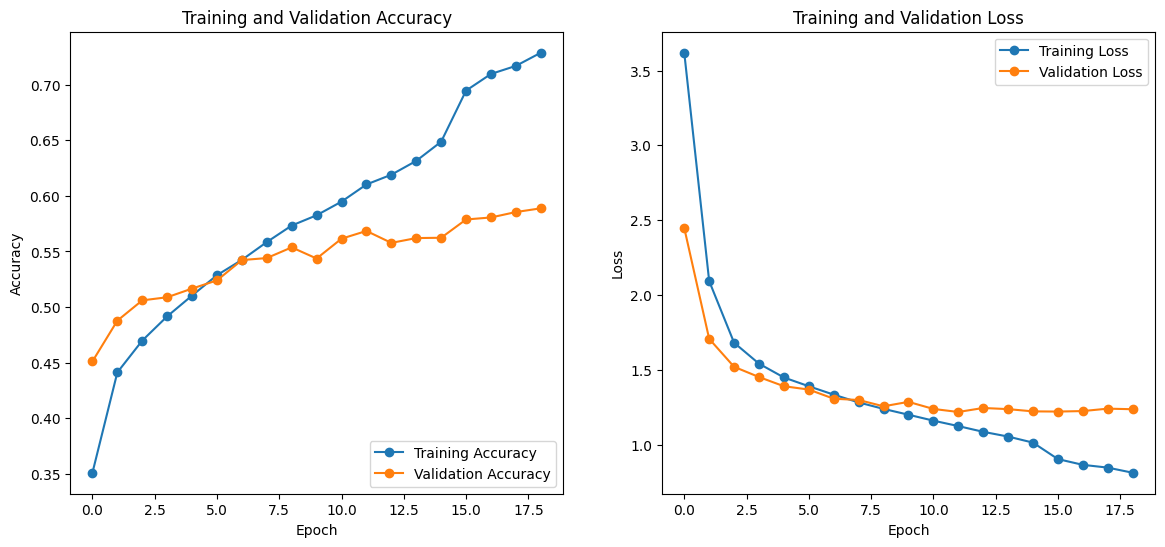

In [5]:
train_final_tuned_model()